## <center> Neural Networks Health Prediction project <center>
<center>Angelo Di Gianvito<center>

### Table of Contents
- [Introduction](#introduction)
- [Importing functions](#importing-functions)
- [Preprocessing](#data-preprocessing)
- [Exploratory Data Analysis](#exploratory-data-analysis-eda)
    - [Age column](#creating-age-column)
    - [Categoricals](#handling-categoricals)
    - [Feature Engineering](#feature-engineering)
    - [Missing values](#missing-values-imputations)
    - [Pipeline](#preprocessing-pipeline)
- [Model](#model)
    - [MultiLayer Perceptron](#tensorflow-keras-mlp-model---predicting-length-of-stay)
    - [Ensemble](#ensemble-model)
- [Conclusion](#conclusion)

### Introduction

In this project I will use a healthcare dataset to gain insights in the differences in characteristics of the patients and predict their length of stay in the hospital. To do it there will be some preprocessing steps to clean the dataset at hand and prepare it for the fitting of the models. I will compare the performances of two models for this problem: MultiLayer Perceptron Neural network model and an Ensemble model using stacking techniques. 

### Importing Functions

First, I import the necessary modules.

In [1]:
# Basic packages
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from numpy import random
import datetime as dt
import category_encoders as ce
import pickle
import shap
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler

# Machine learning libraries and functions
import xgboost as xgb
import sklearn
from sklearn import set_config
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVR 
from sklearn import preprocessing
from sklearn.metrics import  r2_score, mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV, cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier 
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import ExtraTreesRegressor, StackingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasRegressor
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from keras import metrics


import mlens
from mlens.visualization import corrmat
from mlens.ensemble import SuperLearner, BlendEnsemble, Subsemble, SequentialEnsemble



# Ignoring Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

[MLENS] backend: threading


### Importing data

I import the train and test datataset. I also import an extra dataset which contains useful information about the diagnosis of each combination of Patient identifier (subject_id) and Hospital stay identifier (hadm_id).


In [2]:
data_train = pd.read_csv('/Users/user/Desktop/BSE/COURSES/TERM 2/DEEP LEARNING/PROJECTS/SVM & KNN/dl24-probability-of-death-with-k-nn (1)/mimic_train.csv')
data_test = pd.read_csv('/Users/user/Desktop/BSE/COURSES/TERM 2/DEEP LEARNING/PROJECTS/SVM & KNN/dl24-probability-of-death-with-k-nn (1)/mimic_test_death.csv')
data_diagnoses = pd.read_csv('/Users/user/Desktop/BSE/COURSES/TERM 2/DEEP LEARNING/PROJECTS/SVM & KNN/dl24-probability-of-death-with-k-nn (1)/MIMIC_diagnoses.csv')

### Creating the DataFrames

In [3]:
df_train = pd.DataFrame(data_train)
df_test = pd.DataFrame(data_test)
df_diagnoses = pd.DataFrame(data_diagnoses)
df_diagnoses.head()

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,256,108811,1.0,53240
1,256,108811,2.0,41071
2,256,108811,3.0,53560
3,256,108811,4.0,40390
4,256,108811,5.0,5859


The columns in the diagnoses dataset were renamed to match the names they have in the main data and allow merging later on.

In [4]:
# df_diagnoses.rename(columns={'SUBJECT_ID': 'subject_id','HADM_ID': 'hadm_id','ICD9_CODE': 'ICD9_diagnosis'}, inplace=True)

df_diagnoses.rename(columns={'ICD9_CODE': 'ICD9_diagnosis'}, inplace=True)

## Exploratory Data Analysis (EDA)

### Summary Statistics main data

In [5]:
# Set option to display all columns
pd.set_option('display.max_columns', None)

print(f"The train data has a shape of {df_train.shape[0]} rows and {df_train.shape[1]} columns.\n\nThe test data has a shape of {df_test.shape[0]} rows and {df_test.shape[1]} columns.")

print(f"\nThe descriptives of the train Dataframe are the following:")
display(df_train.describe())

The train data has a shape of 20885 rows and 44 columns.

The test data has a shape of 5221 rows and 39 columns.

The descriptives of the train Dataframe are the following:


,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff,LOS
count,20885.000000,20885.000000,20885.000000,20885.000000,18698.000000,18698.000000,18698.000000,18677.000000,18677.000000,18677.000000,18676.000000,18676.000000,18676.000000,18699.000000,18699.000000,18699.000000,18696.000000,18696.000000,18696.000000,18388.000000,18388.000000,18388.000000,18682.000000,18682.000000,18682.000000,20632.000000,20632.000000,20632.000000,20885.000000,20885.000000
mean,0.112282,58950.496098,150082.402298,250202.495523,69.705904,105.239801,85.180250,91.110564,150.725920,119.145423,44.327854,88.360784,62.511614,56.293064,107.074282,77.609535,11.919207,27.780220,18.985855,36.051208,37.428781,36.751717,91.007494,99.555883,96.866685,106.781975,182.129604,138.856428,-51617.069830,3.701046
std,0.315720,25299.439535,28898.479845,28909.806302,14.869840,20.922613,15.318208,17.532534,23.833793,16.701503,11.909852,19.285554,11.010790,14.348780,27.585990,11.113299,3.572189,6.278514,3.849713,0.732124,0.799897,0.603476,7.399390,1.159792,2.333108,35.178811,92.665603,44.933145,10686.395846,5.175721
min,0.000000,23.000000,100001.000000,200001.000000,2.000000,39.000000,34.714286,5.000000,46.000000,46.000000,4.000000,27.000000,17.000000,1.000000,29.000000,25.759907,1.000000,12.000000,9.291667,15.000000,30.800000,30.666667,1.000000,57.000000,47.666667,2.000000,42.000000,42.000000,-72740.274440,0.056600
25%,0.000000,41132.000000,125157.000000,225153.000000,60.000000,90.000000,74.272727,81.000000,134.000000,107.100000,37.000000,75.000000,54.950952,49.000000,91.000000,70.033908,10.000000,23.000000,16.250000,35.666667,36.944444,36.388889,90.000000,100.000000,95.812500,86.000000,126.000000,110.750000,-60864.454110,1.165400
50%,0.000000,60441.000000,150152.000000,250452.000000,69.000000,103.000000,84.131183,90.000000,148.000000,116.901961,44.000000,86.000000,61.423660,57.000000,102.000000,76.294118,12.000000,27.000000,18.382353,36.111111,37.333333,36.731481,92.000000,100.000000,97.142857,102.000000,161.000000,128.666667,-51561.703460,2.020800
75%,0.000000,80286.000000,175017.000000,275303.000000,79.000000,118.000000,95.185588,101.000000,164.000000,129.465116,51.000000,98.000000,68.954545,64.000000,116.000000,84.041774,14.000000,31.000000,21.105543,36.500000,37.888889,37.092593,94.000000,100.000000,98.346154,121.000000,206.000000,154.578571,-42327.560030,3.915800
max,1.000000,99999.000000,199999.000000,299998.000000,141.000000,280.000000,163.875000,181.000000,323.000000,202.172414,105.000000,294.000000,121.489362,122.000000,299.000000,136.652174,31.000000,69.000000,41.235294,40.100000,42.000000,40.238333,100.000000,100.000000,100.000000,563.000000,2440.000000,771.900000,-32157.494580,101.739000


### Summary Statistics diagnoses dataframe


In [6]:
df_train

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,DOB,DOD,ADMITTIME,DISCHTIME,DEATHTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,59.0,94.0,74.543478,15.0,30.0,22.347826,35.111111,36.944444,36.080247,90.0,99.0,95.739130,111.0,230.0,160.777778,F,2108-07-16 00:00:00,2180-03-09 00:00:00,2178-02-06 10:35:00,2178-02-13 18:30:00,NaN,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,58.0,84.0,74.800000,13.0,21.0,16.058824,36.333333,36.611111,36.472222,98.0,100.0,99.058824,103.0,103.0,103.000000,F,2087-01-16 00:00:00,NaN,2129-02-12 22:34:00,2129-02-13 16:20:00,NaN,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,0.7582
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,67.0,56.821429,64.0,88.0,72.888889,13.0,21.0,15.900000,36.444444,36.888889,36.666667,100.0,100.0,100.000000,132.0,346.0,217.636364,F,2057-09-17 00:00:00,NaN,2125-11-17 23:04:00,2125-12-05 17:55:00,NaN,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,3.7626
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,89.0,41.864865,48.0,94.0,62.783784,12.0,35.0,26.771429,36.333333,39.500000,37.833333,78.0,100.0,95.085714,108.0,139.0,125.000000,F,2056-02-27 00:00:00,2132-03-01 00:00:00,2131-01-26 08:00:00,2131-02-05 16:23:00,NaN,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,3.8734
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,137.0,113.000000,F,2066-12-19 00:00:00,2147-01-18 00:00:00,2146-05-04 02:02:00,2146-05-20 18:40:00,NaN,-50271.76602,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,5.8654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20880,0,28043,135417,244530,65.0,92.0,78.500000,60.0,160.0,110.976190,34.0,94.0,56.595238,41.0,102.0,69.285714,10.0,23.0,15.420000,35.555556,36.611111,36.155556,97.0,100.0,99.833333,68.0,139.0,103.571429,M,2088-12-15 00:00:00,2177-02-02 00:00:00,2176-06-17 06:36:00,2176-07-04 14:01:00,NaN,-60714.92678,EMERGENCY,Medicare,CATHOLIC,MARRIED,WHITE,ALTERED MENTAL STATUS,3229,MICU,11.6116
20881,0,87605,191007,216116,74.0,112.0,89.156250,100.0,150.0,123.272727,58.0,83.0,67.818182,74.0,99.0,82.363636,9.0,24.0,14.781250,37.055556,37.777778,37.476190,95.0,100.0,97.531250,184.0,377.0,245.400000,M,2071-11-18 00:00:00,NaN,2137-09-27 23:14:00,2137-10-05 13:00:00,NaN,-46217.77777,EMERGENCY,Private,NOT SPECIFIED,MARRIED,BLACK/HAITIAN,NEW BRAIN MASS,1918,SICU,1.1593
20882,0,47492,152608,274507,58.0,97.0,76.933333,94.0,131.0,112.037037,55.0,83.0,67.370370,66.0,95.0,78.500000,14.0,27.0,18.166667,36.055556,37.277778,37.007937,97.0,100.0,99.200000,51.0,460.0,190.000000,F,2055-11-27 00:00:00,NaN,2118-10-18 17:54:00,2118-10-21 15:37:00,NaN,-39830.10848,EMERGENCY,Private,PROTESTANT QUAKER,DIVORCED,BLACK/AFRICAN AMERICAN,HYPOGLYCEMIA,24980,MICU,1.8830
20883,0,62946,191485,225930,59.0,102.0,81.844444,96.0,150.0,123.837209,47.0,85.0,60.232558,65.0,92.0,75.883721,15.0,27.0,19.044444,35.833333,37.722222,36.635417,91.0,100.0,96.311111,91.0,91.0,91.000000,F,1871-07-17 00:00:00,NaN,2171-07-17 21:24:00,2171-07-22 14:35:00,NaN,-59205.26841,EMERGENCY,Medicare,PROTESTANT QUAKER,WIDOWED,WHITE,CORONARY ARTERY DISEAS

In [7]:
# Display dataframe
print(f"The diagnoese data has shape: {df_diagnoses.shape[0]} rows and {df_diagnoses.shape[1]} columns.")
print("\nDescriptives:")
display(df_diagnoses.describe())

The diagnoese data has shape: 651047 rows and 4 columns.

Descriptives:


,SUBJECT_ID,HADM_ID,SEQ_NUM
count,651047.000000,651047.000000,651000.000000
mean,38971.159758,150017.744819,7.913836
std,29372.198841,28878.068648,6.072633
min,2.000000,100001.000000,1.000000
25%,14562.500000,125028.000000,3.000000
50%,28671.000000,150140.000000,6.000000
75%,63715.000000,174978.000000,11.000000
max,99999.000000,199999.000000,39.000000


### Dropping unneded columns

Train and test data have some columns which are not in common and will not be used for encoding purposes, so they will be dropped.

In [8]:
# Get the columns of each DataFrame
train_columns = set(df_train.columns)
test_columns = set(df_test.columns)

# Find the columns that are in df_train but not in df_test
train_not_in_test = train_columns - test_columns

# Find the columns that are in df_test but not in df_train
test_not_in_train = test_columns - train_columns

# Combine both sets to get all different columns
different_columns = train_not_in_test.union(test_not_in_train)

print("Columns to drop because different between df_train and df_test:", different_columns)


Columns to drop because different between df_train and df_test: {'DOD', 'DEATHTIME', 'LOS', 'HOSPITAL_EXPIRE_FLAG', 'DISCHTIME'}


I will drop the columns that cannot be used for prediction.

In [9]:
train_not_in_test={'DISCHTIME', 'DOD', 'DEATHTIME'}
df_train.drop(columns=train_not_in_test, inplace=True)

### Variable Types Exploration

In [10]:
# Dataframe variable types
var_types=df_train.dtypes
print(f"\nThe variable types of the train Dataframe are the following:")
display(var_types)



The variable types of the train Dataframe are the following:


HOSPITAL_EXPIRE_FLAG      int64
subject_id                int64
hadm_id                   int64
icustay_id                int64
HeartRate_Min           float64
HeartRate_Max           float64
HeartRate_Mean          float64
SysBP_Min               float64
SysBP_Max               float64
SysBP_Mean              float64
DiasBP_Min              float64
DiasBP_Max              float64
DiasBP_Mean             float64
MeanBP_Min              float64
MeanBP_Max              float64
MeanBP_Mean             float64
RespRate_Min            float64
RespRate_Max            float64
RespRate_Mean           float64
TempC_Min               float64
TempC_Max               float64
TempC_Mean              float64
SpO2_Min                float64
SpO2_Max                float64
SpO2_Mean               float64
Glucose_Min             float64
Glucose_Max             float64
Glucose_Mean            float64
GENDER                   object
DOB                      object
ADMITTIME                object
Diff    

In [11]:
print('Column list:\n',df_train.columns)

Column list:
 Index(['HOSPITAL_EXPIRE_FLAG', 'subject_id', 'hadm_id', 'icustay_id',
       'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER', 'DOB', 'ADMITTIME', 'Diff', 'ADMISSION_TYPE',
       'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS',
       'ICD9_diagnosis', 'FIRST_CAREUNIT', 'LOS'],
      dtype='object')


### Distribution of LOS variable

The variable appears to be strongly skewed to the right, however extreme values can be important for prediction, so no preprocessing will be done on the variable.

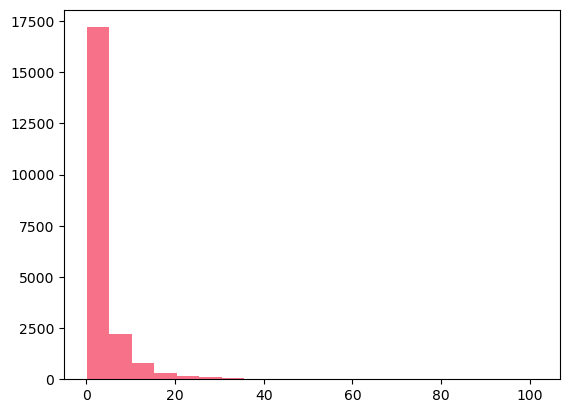

In [12]:
plt.hist(df_train['LOS'], bins=20)
plt.show()

## Data Preprocessing

### Creating Age Column

The columns Date of birth and admission time were used to compute the age of the patient. Using the 'Diff' column and the funciton datetime they were transformed into the number of days since they were born and then transofrmed back into the years of the patient. A plot was created to check the distribution of the created variable.

In [13]:
for data in [df_train, df_test]:
    # Convert admittime to date, adding "Diff" to make the dates realistic
    data['ADMITTIME'] = (pd.to_datetime(data['ADMITTIME']) + data["Diff"].apply(lambda x: dt.timedelta(x))).apply(lambda x: x.date())
    # Convert dob to date, adding "Diff" to make the dates realistic
    data['DOB'] = (pd.to_datetime(data['DOB']) + data["Diff"].apply(lambda x: dt.timedelta(x))).apply(lambda x: x.date())
    # Convert to age in years
    data['age'] = data.apply(lambda x: int((x['ADMITTIME'] - x['DOB']).days/365), axis=1)

df_train['age'] = df_train['age'].apply(lambda x: x if x < 90 else 90)
df_test['age'] = df_test['age'].apply(lambda x: x if x < 90 else 90)

df_train = df_train.drop(['DOB', 'Diff'], axis = 1)
df_test = df_test.drop(['DOB','Diff'], axis = 1)


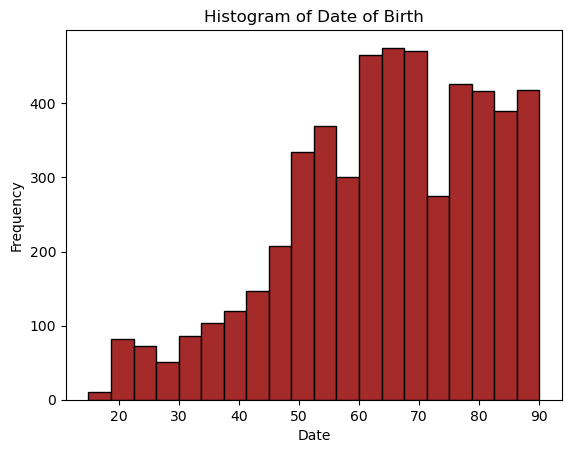

In [14]:
# Plotting the age distribution in the data
plt.hist(df_test['age'], bins=20, color='brown', edgecolor='black') 
plt.title('Histogram of Date of Birth')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.show()

We can see from the histogram that the distribution is left skewed, probably because older people are more likely to end up in the hospital and consequently to incur in deathly conditions. This is an interesting carachteristic of the data.

## Handling Categoricals

### Marital Status

For the marital status column there were some missing value that were filled with one of the used parameters in the column which is the value 'UNKNOWN'. They will later on be processed with one hot encoding due to their low cardinality.

In [15]:
df_train['MARITAL_STATUS'].value_counts()

MARITAL_STATUS
MARRIED              9664
SINGLE               5910
WIDOWED              2819
DIVORCED             1413
SEPARATED             240
UNKNOWN (DEFAULT)     103
LIFE PARTNER           14
Name: count, dtype: int64

In [16]:
df_train['MARITAL_STATUS'] = df_train['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')
df_test['MARITAL_STATUS'] = df_test['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')

For the purpose of our study can be interesting to know if the patient has a partner or it has not. For this reason we will reduce dimensionality of these relatively sparse categories to just married or not married, which represent people that have a partner and people that don't.

In [17]:
df_train['MARITAL_STATUS'] = df_train['MARITAL_STATUS'].apply(lambda x: x if x != 'LIFE PARTNER' else 'MARRIED')
df_train['MARITAL_STATUS'] = df_train['MARITAL_STATUS'].apply(lambda x: x if x == 'MARRIED' else 'NOT MARRIED')
df_test['MARITAL_STATUS'] = df_train['MARITAL_STATUS'].apply(lambda x: x if x != 'LIFE PARTNER' else 'MARRIED')
df_test['MARITAL_STATUS'] = df_train['MARITAL_STATUS'].apply(lambda x: x if x == 'MARRIED' else 'NOT MARRIED')

In [18]:
df_train['MARITAL_STATUS'].value_counts()

MARITAL_STATUS
NOT MARRIED    11207
MARRIED         9678
Name: count, dtype: int64

### Religion

For the religion column, the value counts per religion show that the variable has a high cardinality. However, there is a great presence of 'catholics', 'protestants' and 'jewish', the other religions are of a much smaller proportion. To encode this variable we can reduce dimensionality identifying all the smaller classes and grouping these religions together in a unique class: 'Other'. Differently from marital status we will keep some sparsity in the variable instead of reducing it to a bianry variable.

In [19]:
df_train['RELIGION'].value_counts()

RELIGION
CATHOLIC                  7655
NOT SPECIFIED             5398
PROTESTANT QUAKER         2753
JEWISH                    1840
UNOBTAINABLE              1515
OTHER                      702
EPISCOPALIAN               288
GREEK ORTHODOX             178
CHRISTIAN SCIENTIST        164
BUDDHIST                   109
MUSLIM                      74
UNITARIAN-UNIVERSALIST      54
JEHOVAH'S WITNESS           45
ROMANIAN EAST. ORTH         41
HINDU                       38
7TH DAY ADVENTIST           30
HEBREW                       1
Name: count, dtype: int64

In [20]:
religion_other = ['HEBREW', 'UNITARIAN-UNIVERSALIST', 'HINDU', 'GREEK ORTHODOX',"JEHOVAH'S WITNESS", "BUDDHIST", 'MUSLIM', 'OTHER', 'CHRISTIAN SCIENTIST', 'EPISCOPALIAN', 'ROMANIAN EAST. ORTH', '7TH DAY ADVENTIST']
df_train['RELIGION'] = df_train['RELIGION'].replace(religion_other, 'OTHER')
df_test['RELIGION'] = df_test['RELIGION'].replace(religion_other, 'OTHER')

df_train['RELIGION'].value_counts()

RELIGION
CATHOLIC             7655
NOT SPECIFIED        5398
PROTESTANT QUAKER    2753
JEWISH               1840
OTHER                1724
UNOBTAINABLE         1515
Name: count, dtype: int64

In [21]:
df_test['RELIGION'].value_counts()

RELIGION
CATHOLIC             1898
NOT SPECIFIED        1361
PROTESTANT QUAKER     697
JEWISH                446
OTHER                 424
UNOBTAINABLE          395
Name: count, dtype: int64

### Ethnicity

Ethnicity is a very spare categorical variable. To handle it we will group the similar ehtnicities together based on their names, the remaining less prevalent ethnicities will be grouped in a similar way to religions, in the class 'Other'.

In [22]:
df_train['ETHNICITY'].value_counts()

ETHNICITY
WHITE                                                       15112
BLACK/AFRICAN AMERICAN                                       1977
UNABLE TO OBTAIN                                              577
UNKNOWN/NOT SPECIFIED                                         568
HISPANIC OR LATINO                                            562
OTHER                                                         489
ASIAN                                                         265
PATIENT DECLINED TO ANSWER                                    175
HISPANIC/LATINO - PUERTO RICAN                                155
ASIAN - CHINESE                                               146
BLACK/CAPE VERDEAN                                            126
WHITE - RUSSIAN                                               117
BLACK/HAITIAN                                                  72
HISPANIC/LATINO - DOMINICAN                                    59
ASIAN - ASIAN INDIAN                                           58


ethnicities will be grouped based on some general words that appear in the name, such as "WHITE", "BLACK" or "LATINO". If these words appear in the ethnicity name they will be grouped to the general class, if they don't appear they will be grouped to the class "OTHER". This will successfully reduce dimensionality maintaining some important information.

In [23]:
def encode_ethnicity(ethnicity, ethn_type):
  if pd.isna(ethnicity):
    return np.nan
  else:
    print(ethnicity)
    return 1 if ethn_type in ethnicity.upper() else 0
  
# Manually encoding the rest
ethnic_replacements = {
    'UNKNOWN': ['UNABLE TO OBTAIN', 'UNKNOWN/NOT SPECIFIED', 'PATIENT DECLINED TO ANSWER'],
    'OTHER': ['AMERICAN INDIAN/ALASKA NATIVE', 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE',
              'CARIBBEAN ISLAND', 'MIDDLE EASTERN', 'OTHER', 'PORTUGUESE',
              'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'MULTI RACE ETHNICITY', 'SOUTH AMERICAN']
}
ethnicities = ["WHITE", "ASIAN", "BLACK", "LATINO", "UNKNOWN", "OTHER"]

df_train['ETHNICITY'] = df_train['ETHNICITY'].fillna('UNKNOWN') 
df_test['ETHNICITY'] = df_test['ETHNICITY'].fillna('UNKNOWN') 

df_train['ETHNICITY'] = df_train['ETHNICITY'].apply(lambda x: x if type(x) is str else 'UNKNOWN') 
df_test['ETHNICITY'] = df_test['ETHNICITY'].apply(lambda x: x if type(x) is str else 'UNKNOWN') 

for group, values in ethnic_replacements.items():
    df_train['ETHNICITY'] = df_train['ETHNICITY'].replace(values, group)
    df_test['ETHNICITY'] = df_test['ETHNICITY'].replace(values, group)
    
for ethn in ethnicities:
    df_train['ETHNICITY'] = df_train['ETHNICITY'].apply(lambda x: x if ethn not in x.upper() else ethn)
    df_test['ETHNICITY'] = df_test['ETHNICITY'].apply(lambda x: x if ethn not in x.upper() else ethn)



In [24]:
df_train['ETHNICITY'].value_counts()

ETHNICITY
WHITE      15330
BLACK       2201
UNKNOWN     1320
LATINO       852
OTHER        637
ASIAN        545
Name: count, dtype: int64

### One Hot Encoding categoricals

The categorical caridanilty was checked and the ones that had a low one were selected and one hot encoding will be performed in the pipeline. High cardinality variables were dropped ('DIAGNOSIS'). A one hoe encoder for categoricals is defined.

In [25]:
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

drop_cols = ['DIAGNOSIS']
df_train.drop(drop_cols, axis=1, inplace=True)
df_test.drop(drop_cols, axis=1, inplace=True)

## Feature Engineering

In this section some variables were manipulated to obtain additional infomration that can be useful for prediction.

### Creating Differentials for numerical variables with max and min values

Some variables had minimum and maximum values, this could provide additional information, useful for prediction. Hence, the range between max and min was computed and the differentials were stored as new variables.

In [29]:
# Replace min and max with range
features = ['DiasBP', 'Glucose', 'HeartRate', 'MeanBP', 'RespRate', 'SpO2', 'SysBP', 'TempC']

# Iterate through each feature and calculate the differences
for feature in features:
    min_col = f"{feature}_Min"
    max_col = f"{feature}_Max"
    diff_col = f"{feature}_Differential"
    
    # Calculate the difference and create a new column
    df_train[diff_col] = df_train[max_col] - df_train[min_col]
    df_test[diff_col] = df_test[max_col] - df_test[min_col]

    # Drop the original min and max columns
    df_train.drop(columns=[min_col, max_col], inplace=True)
    df_test.drop(columns=[min_col, max_col], inplace=True)

### Creating Number of visits per patient Column

Some patients were found to be admitted several times, so it could be inferred they were particularly ill. This was considered as a factor that was possibly confounding the results, so it was worth exploring further and accounting for it in the model.

In [30]:
# Checking the number of admissions per subject
admission_count = df_train['subject_id'].value_counts()
admission_count = admission_count.sort_values(ascending=False)
ill_subjects = []
for i in range (len(admission_count)):
    if admission_count.values[i] > 10:
        ill_subjects.append(admission_count.keys()[i])

print(f'The subjects that were particularly ill, so admitted several times are:\n\n{ill_subjects}')


The subjects that were particularly ill, so admitted several times are:

[109, 73713, 23657, 5060, 29035, 11861, 76327, 31260, 5727, 3952, 7809]


A variable with the number of visits per patient was created to account for this factor in the model.

In [31]:
df_train["number_of_visits"] = df_train.sort_values(['subject_id', 'ADMITTIME']).groupby(["subject_id"]).cumcount() + 1
df_test["number_of_visits"] = df_test.sort_values(['subject_id', 'ADMITTIME']).groupby(["subject_id"]).cumcount() + 1

Checking the results.

In [32]:
df_train["number_of_visits"].sort_values(ascending=False)

10893    25
4323     24
9467     23
1185     22
5013     21
         ..
7685      1
7683      1
7682      1
7681      1
20884     1
Name: number_of_visits, Length: 20885, dtype: int64

### Creating Number of Concurrent Diseases Column in diagnoses dataset

From the additional dataset it appeared that patients had concurrent diseases when admitted to the hospital, this can provide insightful information and affect prediction, so it was accounted for in the variable "number_of_diseases". The datasets will be merged and the nnumber of concurrent diseases computed.

In [33]:
# Computing the number of concurrent diseases in each of the ICU stays
df_diagnoses_temp = df_diagnoses.copy()
number_comorbidities_patient = df_diagnoses_temp.groupby(["SUBJECT_ID", "HADM_ID"]).max()["SEQ_NUM"].reset_index()
number_comorbidities_patient = number_comorbidities_patient.rename({"SEQ_NUM": "number_of_diseases"}, axis=1)

Merging the datasets

In [34]:
# Join with training set
df_train = pd.merge(df_train, number_comorbidities_patient, left_on=["subject_id", "hadm_id"], right_on = ["SUBJECT_ID", "HADM_ID"], how = "left").drop(["SUBJECT_ID", "HADM_ID"], axis=1)
# Join with test set
df_test = pd.merge(df_test, number_comorbidities_patient, left_on=["subject_id", "hadm_id"], right_on = ["SUBJECT_ID", "HADM_ID"], how = "left").drop(["SUBJECT_ID", "HADM_ID"], axis=1)

Checking the results.

In [35]:
df_train['number_of_diseases'].sort_values(ascending=False)

10784    39.0
13264    39.0
4477     39.0
2744     39.0
8200     39.0
         ... 
7251      1.0
15526     1.0
17818     1.0
2772      1.0
916       1.0
Name: number_of_diseases, Length: 20885, dtype: float64

## Missing values imputations

The datasets have several missing data in some specific variables. This missing data has to be imputed to perform prediction.

Missing values per column:

HOSPITAL_EXPIRE_FLAG       0.00
subject_id                 0.00
hadm_id                    0.00
icustay_id                 0.00
HeartRate_Mean            10.47
SysBP_Mean                10.57
DiasBP_Mean               10.58
MeanBP_Mean               10.47
RespRate_Mean             10.48
TempC_Mean                11.96
SpO2_Mean                 10.55
Glucose_Mean               1.21
GENDER                     0.00
ADMITTIME                  0.00
ADMISSION_TYPE             0.00
INSURANCE                  0.00
RELIGION                   0.00
MARITAL_STATUS             0.00
ETHNICITY                  0.00
ICD9_diagnosis             0.00
FIRST_CAREUNIT             0.00
LOS                        0.00
age                        0.00
DiasBP_Differential       10.58
Glucose_Differential       1.21
HeartRate_Differential    10.47
MeanBP_Differential       10.47
RespRate_Differential     10.48
SpO2_Differential         10.55
SysBP_Differential        10.57
TempC_Differ

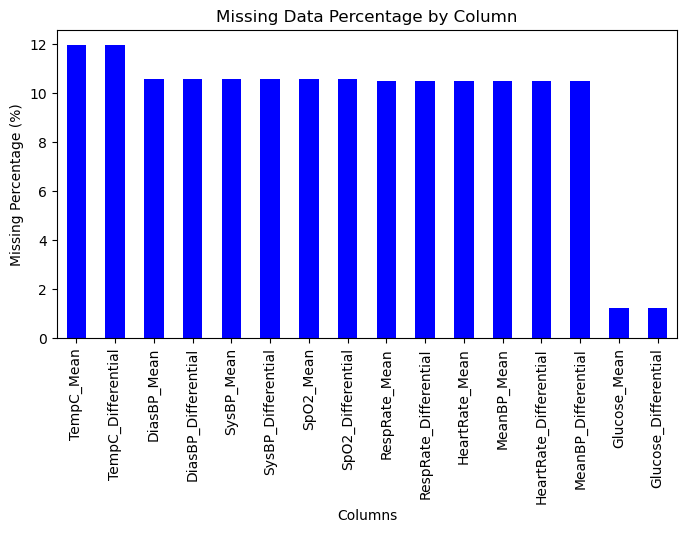

In [36]:
# Checking missing values by column

# Calculate missing percentages
missing_percentages = (df_train.isnull().mean() * 100).round(2)

# Check if there are any missing values
if missing_percentages.empty:
    print("No missing values in the DataFrame.")
else:
    # Print missing values per column
    print("Missing values per column:\n")
    print(missing_percentages)

    # Filter columns with missing values
    missing_columns = missing_percentages[missing_percentages > 0]

    # Check if there are any columns with missing values
    if not missing_columns.empty:
        # Sort columns by missing percentage in descending order
        missing_columns = missing_columns.sort_values(ascending=False)

        # Plot missing percentages
        plt.figure(figsize=(8, 4))
        missing_columns.plot.bar(color='blue')
        plt.title('Missing Data Percentage by Column')
        plt.xlabel('Columns')
        plt.ylabel('Missing Percentage (%)')
        plt.show()
    else:
        print("\nNo columns have missing values.")


#### Drop columns with high missing percentage

For robustness, columns with a very high missing percentage will be dropped from the dataframe. A treshold is set at 70% of missing data and in this case there are no columns that have such missing percentage. It was still included in the notebook for completeness and reproducibility.

In [37]:
# Set a threshold for missing percentage
threshold = 70

# Filter columns to drop based on missing percentage
columns_to_drop = missing_columns[missing_columns > threshold].index

# Drop columns with missing percentage higher than 75
df_train = df_train.drop(columns=columns_to_drop)
df_test = df_test.drop(columns=columns_to_drop)

# Print the columns that were dropped
if len(columns_to_drop) > 0:
    print("Columns dropped due to high missing percentage:\n", columns_to_drop)
else:
    print("No columns were dropped.")


No columns were dropped.


### Backward/Forward filling

We will impute using backward and forward filling before applying other imputations strategies, using the data from the multiple visits of the patient. 

In [38]:
before_missing = df_train.isnull().sum()

df_train = df_train.groupby(['subject_id'], as_index = False).apply(lambda x: x.ffill())
df_test = df_test.groupby(['subject_id'], as_index = False).apply(lambda x: x.ffill())

df_train = df_train.groupby(['subject_id'], as_index = False).apply(lambda x: x.bfill())
df_test = df_test.groupby(['subject_id'], as_index = False).apply(lambda x: x.bfill())

now_missing = df_train.isnull().sum()

print("Imputed values per column:\n")
print((before_missing - now_missing).sort_values(ascending=False))

Imputed values per column:

TempC_Differential        469
TempC_Mean                469
DiasBP_Differential       404
SysBP_Mean                404
DiasBP_Mean               404
SysBP_Differential        404
SpO2_Mean                 403
SpO2_Differential         403
RespRate_Mean             402
RespRate_Differential     402
HeartRate_Differential    400
HeartRate_Mean            400
MeanBP_Mean               398
MeanBP_Differential       398
Glucose_Differential       62
Glucose_Mean               62
HOSPITAL_EXPIRE_FLAG        0
LOS                         0
number_of_visits            0
age                         0
RELIGION                    0
FIRST_CAREUNIT              0
ICD9_diagnosis              0
ETHNICITY                   0
MARITAL_STATUS              0
subject_id                  0
INSURANCE                   0
ADMISSION_TYPE              0
ADMITTIME                   0
GENDER                      0
icustay_id                  0
hadm_id                     0
number_of_di

### Imputing with means

Some imputation strategies were attempted such as KNN imputations. The results in the final predicitons were less accurate with these strategies compared to standard mean imputations. A simple imputer was used to fill the missing data.

In [39]:
simple_imputer = SimpleImputer(strategy='mean')

### Target Encoding ICD9 diagnosis 

ICD9 codes indicate the code associated with the doagnosis, so are a very important feature to predict the intensity of the disease and mortality. Therefore, target encoding will be conducted to improve the prediction score of the length of stay in the hospital for the patients.

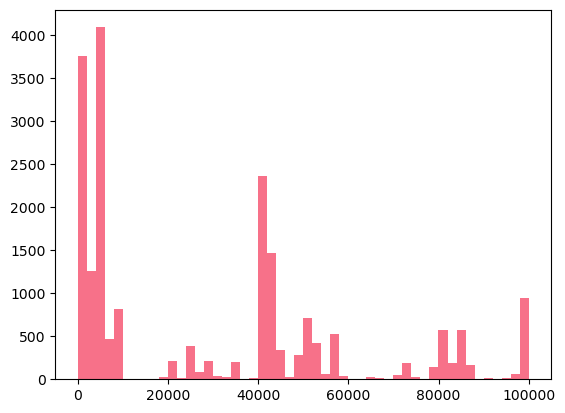

In [41]:
df_trial = df_train[~df_train['ICD9_diagnosis'].str.contains('V')]
plt.hist(pd.to_numeric(df_trial['ICD9_diagnosis']), bins=50)
plt.show()

In [43]:
df_diagnoses_temp = df_diagnoses.copy()

In [44]:
df_diagnoses_temp

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_diagnosis
0,256,108811,1.0,53240
1,256,108811,2.0,41071
2,256,108811,3.0,53560
3,256,108811,4.0,40390
4,256,108811,5.0,5859
...,...,...,...,...
651042,65535,178280,5.0,5119
651043,65535,178280,6.0,5990
651044,65535,178280,7.0,0414
651045,65535,178280,8.0,25000


The diagnoses extra dataset was used to encode the diagnosis and later on to create extra features for prediction for each of the patients. The features will be created using target encoding based on the average mortality for that particular disease. A target encoder was defined with a smoothing parameter. The smoothing is necessary as the above plot shows that for some diseases there is a occurrence in the data while for others very low. Smoothing prevents that the probabilities overfit to the data.

The datasets were merged limiting to 10 the number of concurrent diseases being considered for each patient. Then the concurrent diseases will be target encoding based on the average mortality associated with that disease. Finally, an average mortality index will be computed from the average of these values.

In [45]:
df_diagnoses_temp = df_diagnoses_temp[df_diagnoses_temp['SEQ_NUM'].between(2, 10)]
df_diagnoses_temp = df_diagnoses_temp.pivot(index=['SUBJECT_ID', 'HADM_ID'], columns= 'SEQ_NUM', values='ICD9_diagnosis')
df_diagnoses_temp = df_diagnoses_temp.reset_index()
df_diagnoses_temp.columns = ['SUBJECT_ID'] + ['HADM_ID'] + [f'ICD9_{int(col)}' for col in df_diagnoses_temp.columns[2:]]
df_train = pd.merge(df_train, df_diagnoses_temp, left_on=['subject_id', 'hadm_id'], right_on=['SUBJECT_ID', 'HADM_ID'], how='left').drop(["SUBJECT_ID", "HADM_ID"], axis=1)
df_test = pd.merge(df_test, df_diagnoses_temp, left_on=['subject_id', 'hadm_id'], right_on=['SUBJECT_ID', 'HADM_ID'], how='left').drop(["SUBJECT_ID", "HADM_ID"], axis=1)
df_train.rename(columns={'ICD9_diagnosis': 'ICD9_1.0'}, inplace=True)
df_test.rename(columns={'ICD9_diagnosis': 'ICD9_1.0'}, inplace=True)

In [46]:
diagnoses_cols = ['ICD9_1.0','ICD9_2', 'ICD9_3', 'ICD9_4', 'ICD9_5', 'ICD9_6', 'ICD9_7', 'ICD9_8', 'ICD9_9', 'ICD9_10']
y_train = df_train[['HOSPITAL_EXPIRE_FLAG']]

In [47]:
# Target Encoding for diagnoses

# Initialize TargetEncoder
encoder = ce.TargetEncoder(smoothing=1.0)

# Fit on df_train and y_train
encoder.fit(df_train[diagnoses_cols], y_train)

# Transform df_train and df_test and calculate means
df_train_encoded = encoder.transform(df_train[diagnoses_cols]).mean(axis=1)
df_test_encoded = encoder.transform(df_test[diagnoses_cols]).mean(axis=1)

# Concatenate the encoded means with the original df_train and df_test
df_train = pd.concat([df_train, df_train_encoded.rename('average_mortality')], axis=1)
df_test = pd.concat([df_test, df_test_encoded.rename('average_mortality')], axis=1)

# Drop columns
df_train.drop(diagnoses_cols, axis=1, inplace = True)
df_test.drop(diagnoses_cols, axis=1, inplace = True)


Dropping 'HOSPITAL_EXPIRE_FLAG' column from the train data as it is not present in the df_test

In [48]:
df_train.drop(['HOSPITAL_EXPIRE_FLAG'], axis=1, inplace = True)

## Creating X_train dataframe

Based on the created columns and on the available columns the X_train DataFrame is computed based on the selected columns.

In [49]:
df_train.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'HeartRate_Mean', 'SysBP_Mean',
       'DiasBP_Mean', 'MeanBP_Mean', 'RespRate_Mean', 'TempC_Mean',
       'SpO2_Mean', 'Glucose_Mean', 'GENDER', 'ADMITTIME', 'ADMISSION_TYPE',
       'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY',
       'FIRST_CAREUNIT', 'LOS', 'age', 'DiasBP_Differential',
       'Glucose_Differential', 'HeartRate_Differential', 'MeanBP_Differential',
       'RespRate_Differential', 'SpO2_Differential', 'SysBP_Differential',
       'TempC_Differential', 'number_of_visits', 'number_of_diseases',
       'average_mortality'],
      dtype='object')

I will drop 'ADMITTIME' and the id columns.

In [50]:
y_train = df_train['LOS']
X_train = df_train.drop(['subject_id', 'hadm_id', 'icustay_id', 'ADMITTIME', 'LOS'], axis = 1)
X_test = df_test.drop(['subject_id', 'hadm_id', 'icustay_id', 'ADMITTIME'], axis = 1)


Checking dimensionality is constant between the two dataframes and between X_train and y_train.

In [51]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(20885, 27)
(5221, 27)
(20885,)


## Standardizing

The variables will be standardized fitting on the train dataset values and then transformed for the test and the train data in the pipeline. Continuous variables will be scaled using a robust scaler, one hot encoded  categoricals will be scaled with a Standard Scaler.

In [52]:
num_scaler = RobustScaler()
cat_scaler = StandardScaler()

## Correlation Matrix

Checking linear correlations between the variables for completness.

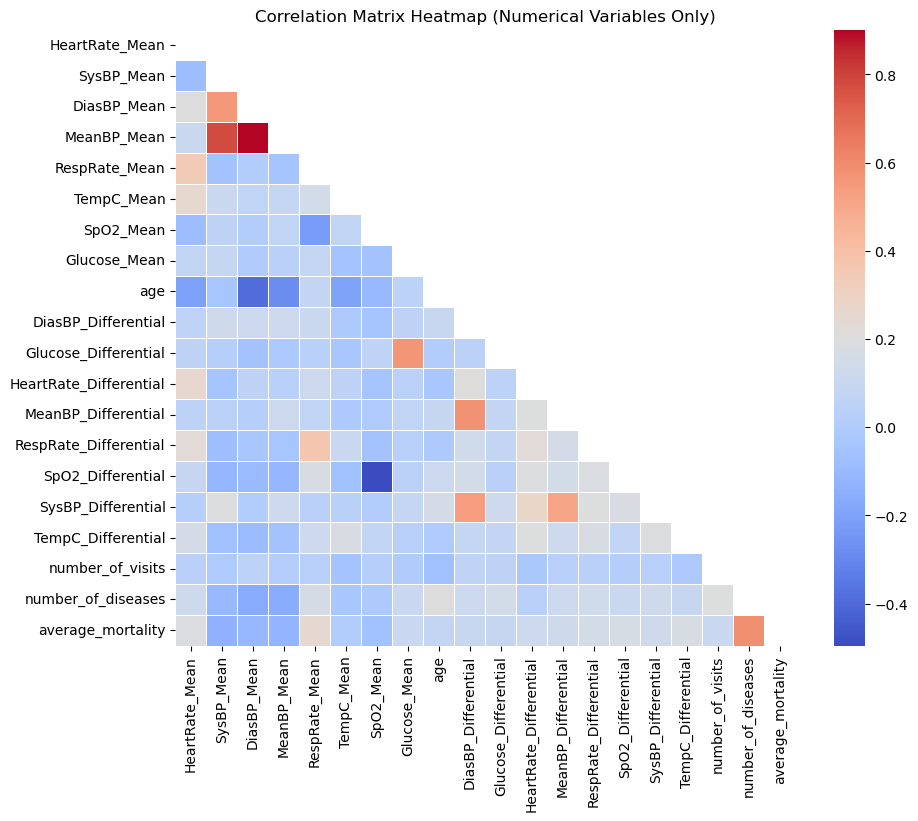

In [53]:
# Selecting numerical columns except those to be excluded
numerical_columns = [col for col in X_train.select_dtypes(include='number').columns]

# Creating a new dataframe with only the selected numerical columns
selected_X_train = X_train[numerical_columns]

# Correlation matrix for selected numerical columns
correlation_matrix = selected_X_train.corr()

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(correlation_matrix)

# Create a heatmap without showing numbers
plt.figure(figsize=(10, 8)) 
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=0.5, mask=matrix)
plt.title("Correlation Matrix Heatmap (Numerical Variables Only)")
plt.show()


We can see from the correlation matrix that some variables are very highly correlated like 'Mean_BP_Mean' and 'DiasBP_Mean'. In case this was a linear relation problem would be important to drop one of these to avoid multicollinearity issues. However, since this is not a linear problem, the variables could have some predictive power, so will be kept them in the dataset.

## Preprocessing Pipeline

In this section the pipeline for the preprocessing will be created and fitted. This makes the code more readable and prevents from data leakage.

Selecting the features of different types for the preprocessing steps.

In [54]:
# Update list of numerical and categorical features
num_features = X_train.select_dtypes(exclude=['object', 'category']).columns

categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

print(f'\nCategoricals: {categorical_features}')
print(f'\nNumericals: {num_features}')


Categoricals: Index(['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'FIRST_CAREUNIT'],
      dtype='object')

Numericals: Index(['HeartRate_Mean', 'SysBP_Mean', 'DiasBP_Mean', 'MeanBP_Mean',
       'RespRate_Mean', 'TempC_Mean', 'SpO2_Mean', 'Glucose_Mean', 'age',
       'DiasBP_Differential', 'Glucose_Differential', 'HeartRate_Differential',
       'MeanBP_Differential', 'RespRate_Differential', 'SpO2_Differential',
       'SysBP_Differential', 'TempC_Differential', 'number_of_visits',
       'number_of_diseases', 'average_mortality'],
      dtype='object')


### Pipeline

In the following code blocks I have created the pipeline for data preprocessing. This was done to prevent from data leakage and provide easy to read code. The pipeline used is very simple and is split in numerical and categorical columns that will be treated differently. 

Target encoding was performed in advance to the preprocessing pipeline as it was based on a different target variable that was then dropped after computing target encoding ('HOSPITAL_EXPIRE_FLAG') as it was not present in the test set. For simplicity it was done in advance. 

In [55]:
# Pipeline for numerical data
num_preprocessing = make_pipeline(
    num_scaler,
    simple_imputer
    )

# Pipeline for categorical data
cat_preprocessing = make_pipeline(
    cat_encoder
    )

In [56]:
# Combine preprocessing pipelines using a columnTransformer
preprocessing = ColumnTransformer(
    [("num", num_preprocessing, num_features),
     ("cat", cat_preprocessing, categorical_features)
     ],
    remainder='drop'
)

Showing the encoding steps for the different variable types.

In [57]:
set_config(display="diagram")
preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('robustscaler',
                                                  RobustScaler()),
                                                 ('simpleimputer',
                                                  SimpleImputer())]),
                                 Index(['HeartRate_Mean', 'SysBP_Mean', 'DiasBP_Mean', 'MeanBP_Mean',
       'RespRate_Mean', 'TempC_Mean', 'SpO2_Mean', 'Glucose_Mean', 'age',
       'DiasBP_Differential', 'Glucose_Differential', 'HeartRate_Differential',
       'MeanBP_Differential', 'RespRat...Differential',
       'SysBP_Differential', 'TempC_Differential', 'number_of_visits',
       'number_of_diseases', 'average_mortality'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 Index(['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'FIRST_CAREUNIT'],
      dtype='object'))])

### Fitting the preprocessing pipeline

In [58]:
X_train_preprocessed= preprocessing.fit_transform(X_train, y_train)
# X_train_preprocessed = preprocessing.transform(X_train)
X_test_preprocessed = preprocessing.transform(X_test)

In [59]:
X_train_preprocessed.shape

(20885, 49)

The new data was combined in new dataframes including the names of the columns created with preprocessing (one hot encoding columns) as it will ease feature importance and model interpretability.

In [60]:
# Get column names after preprocessing
num_feature_names = preprocessing.named_transformers_['num'].named_steps['simpleimputer'].get_feature_names_out(input_features=num_features)
cat_feature_names = preprocessing.named_transformers_['cat'].named_steps['onehotencoder'].get_feature_names_out(input_features=categorical_features)
feature_names = list(num_feature_names) + list(cat_feature_names)

# Combine transformed numerical and categorical features
X_train_combined = pd.DataFrame(X_train_preprocessed, columns=feature_names)

# Combine transformed numerical and categorical features
X_test_combined = pd.DataFrame(X_test_preprocessed, columns=feature_names)

## Model

## Tensorflow Keras MLP Model - Predicting Length of stay

### Simple MLP - No hidden layers

In this section we will fit a multi layer perceptron model on the dataframe at hand. 

We will first start with a small model with no hidden layers and then make the architecture more complicated.

In configuring the MLP regressor for a regression problem, several key parameters are chosen to tailor the model's behavior:

- Adam optimization algorithm is a versatile optimization algorithm that adapts learning rates, so was chosen.

- A moderate starting point for the learning rate, was determined using the default level set at 0.001 which was reasonable and performing well.

- Alpha, representing L2 regularization, is set moderately to prevent overfitting based on the model's complexity and dataset size.

- Early stopping was ecluded to show a more complete history of the loss on the graph and as the model was not overfitting.

- Single hidden layer with 10 neurons to ensure convergence and then increase complexity.

In [66]:
# Build the model.
Keras_MLP = Sequential([
 Dense(10, activation='relu', input_shape=(49,)),
 Dense(1, activation='exponential')
]) 

Keras_MLP.compile(
  optimizer='adam',
  loss='mean_squared_error',
  metrics=[metrics.RootMeanSquaredError()],
)

Fitting the model.

In [67]:
# Fit the model and store the training history
Keras_MLP_history = Keras_MLP.fit(
  X_train_preprocessed,
  y_train,
  epochs=30,
  batch_size=32,
  validation_split=0.3,
  # callbacks=EarlyStopping(monitor='val_loss', patience=3)
)

Epoch 1/30
187/457 [===========>..................] - ETA: 0s - loss: 283.7459 - root_mean_squared_error: 16.8448

457/457 [==============================] - 1s 966us/step - loss: 132.1172 - root_mean_squared_error: 11.4942 - val_loss: 37.7842 - val_root_mean_squared_error: 6.1469
Epoch 2/30
457/457 [==============================] - 0s 725us/step - loss: 31.2117 - root_mean_squared_error: 5.5867 - val_loss: 28.7230 - val_root_mean_squared_error: 5.3594
Epoch 3/30
457/457 [==============================] - 0s 712us/step - loss: 26.9965 - root_mean_squared_error: 5.1958 - val_loss: 27.8938 - val_root_mean_squared_error: 5.2815
Epoch 4/30
457/457 [==============================] - 0s 671us/step - loss: 24.4450 - root_mean_squared_error: 4.9442 - val_loss: 27.1896 - val_root_mean_squared_error: 5.2144
Epoch 5/30
457/457 [==============================] - 0s 668us/step - loss: 23.0906 - root_mean_squared_error: 4.8053 - val_loss: 25.3514 - val_root_mean_squared_error: 5.0350
Epoch 6/30
457/457 [==============================] - 0s 671us/step - loss: 22.3559 - root_mean_squared_error: 4.7282 - val_loss:

Evaluating its performance.

In [68]:
Keras_MLP.evaluate(
  X_train_preprocessed,
  y_train
)

653/653 [==============================] - 0s 384us/step - loss: 19.8475 - root_mean_squared_error: 4.4551


[19.847490310668945, 4.455052375793457]

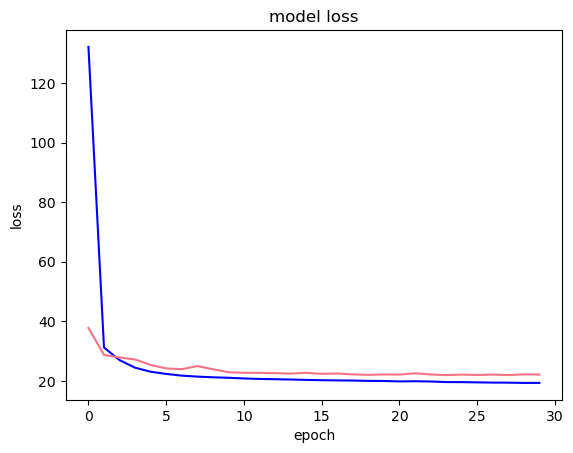

In [69]:
# Assessing convergence
plt.plot(Keras_MLP_history.history['loss'], color='blue')
plt.plot(Keras_MLP_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()


The plot is a visual representation of the convergence behavior of the neural network during training. Convergence refers to the point at which the network's performance stabilizes, indicating that further training is unlikely to provide significant improvements. In this context, the convergence is detected by the flattening of the curve and confirmed by the activation of early stopping, which was employed to stop training when no improvement is observed over a specified number of iterations.

In this case, the graph shows that the model has converged with a simple architecture and default learning rate (0.001). I commented out the early stopping to show a more clear plot of the model converging. I will increase the model complexity to improve the out of sample score.

### Increasing model complexity

In [251]:
# Define the Keras model
keras_reg = Sequential([
    Dense(16, activation='relu', input_shape=(49,), 
            kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
            bias_regularizer=regularizers.l2(1e-4)),
    Dense(1, activation='exponential') 
])

keras_reg.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=[metrics.RootMeanSquaredError()],
)

# Print model summary
keras_reg.summary()

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_149 (Dense)           (None, 16)                800       
                                                                 
 dense_150 (Dense)           (None, 1)                 17        
                                                                 
Total params: 817
Trainable params: 817
Non-trainable params: 0
_________________________________________________________________


fitting the model.

In [252]:
# Fit the model and store the training history
keras_reg_history = keras_reg.fit(
    X_train_preprocessed,
    y_train,
    epochs=70,
    batch_size=32,
    validation_split=0.3,
    # callbacks=EarlyStopping(monitor='val_loss', patience=5),
    verbose=1
)

Epoch 1/70


457/457 [==============================] - 1s 942us/step - loss: 25.0597 - root_mean_squared_error: 5.0056 - val_loss: 22.9776 - val_root_mean_squared_error: 4.7931
Epoch 2/70
457/457 [==============================] - 0s 726us/step - loss: 21.4669 - root_mean_squared_error: 4.6329 - val_loss: 21.8878 - val_root_mean_squared_error: 4.6781
Epoch 3/70
457/457 [==============================] - 0s 686us/step - loss: 20.8570 - root_mean_squared_error: 4.5666 - val_loss: 21.6362 - val_root_mean_squared_error: 4.6511
Epoch 4/70
457/457 [==============================] - 0s 693us/step - loss: 20.4723 - root_mean_squared_error: 4.5242 - val_loss: 21.4728 - val_root_mean_squared_error: 4.6335
Epoch 5/70
457/457 [==============================] - 0s 686us/step - loss: 20.2755 - root_mean_squared_error: 4.5024 - val_loss: 21.3080 - val_root_mean_squared_error: 4.6157
Epoch 6/70
457/457 [==============================] - 0s 681us/step - loss: 19.9985 - root_mean_squared_error: 4.4716 - val_loss: 2

Evaluating the model.

In [253]:
keras_reg.evaluate(
  X_train_preprocessed,
  y_train
)

653/653 [==============================] - 0s 388us/step - loss: 18.1462 - root_mean_squared_error: 4.2588


[18.14617156982422, 4.258823871612549]

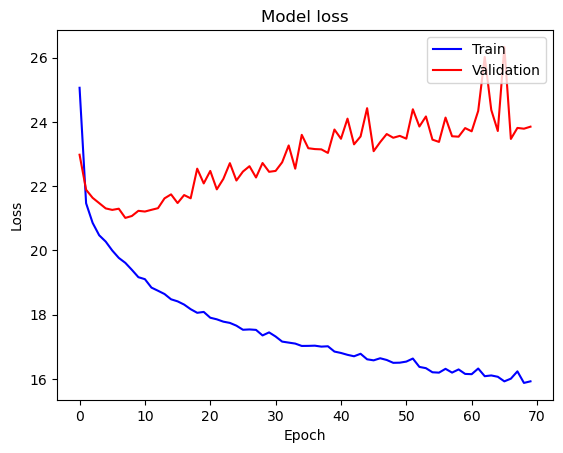

In [254]:
# Plot training & validation loss values
plt.plot(keras_reg_history.history['loss'], color = 'blue')
plt.plot(keras_reg_history.history['val_loss'], color = 'red')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

The plot shows that even with a simple architecture, but with a slighlty higher number of nodes in the first layer, despite l1 and l2 regularization, the model tends to overfit very quickly and is hardly converging. I will add dropout to increase regularization and avoid this from happening.

### Adding Dropout and increasing complexity of the architecture

In [296]:
keras_reg_dropout = Sequential([
    Dense (64, activation = 'relu', input_shape = (49,),
           kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
            bias_regularizer=regularizers.l2(1e-4)),
    Dropout(0.5),
    Dense (64, activation = 'relu',
              kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
            bias_regularizer=regularizers.l2(1e-4)),
    Dropout(0.5),
    Dense(1, activation = 'exponential')
    ])

keras_reg_dropout.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='mean_squared_error',
    metrics=[metrics.RootMeanSquaredError()]
    )
keras_reg_dropout.summary()

Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_178 (Dense)           (None, 64)                3200      
                                                                 
 dropout_89 (Dropout)        (None, 64)                0         
                                                                 
 dense_179 (Dense)           (None, 64)                4160      
                                                                 
 dropout_90 (Dropout)        (None, 64)                0         
                                                                 
 dense_180 (Dense)           (None, 1)                 65        
                                                                 
Total params: 7,425
Trainable params: 7,425
Non-trainable params: 0
_________________________________________________________________


Fitting the model.

In [297]:
history_dropout = keras_reg_dropout.fit(
    X_train_preprocessed,
    y_train,
    epochs = 150,
    batch_size = 32,
    # callbacks = EarlyStopping(monitor = 'val_loss', patience = 8),
    validation_split = 0.3,
    verbose = 1
)

Epoch 1/150
330/457 [====================>.........] - ETA: 0s - loss: 49.6966 - root_mean_squared_error: 7.0482

457/457 [==============================] - 1s 1ms/step - loss: 56.8869 - root_mean_squared_error: 7.5410 - val_loss: 32.7321 - val_root_mean_squared_error: 5.7195
Epoch 2/150
457/457 [==============================] - 0s 1ms/step - loss: 31.9097 - root_mean_squared_error: 5.6471 - val_loss: 30.3983 - val_root_mean_squared_error: 5.5116
Epoch 3/150
457/457 [==============================] - 0s 905us/step - loss: 31.8974 - root_mean_squared_error: 5.6460 - val_loss: 31.6275 - val_root_mean_squared_error: 5.6220
Epoch 4/150
457/457 [==============================] - 0s 907us/step - loss: 29.1954 - root_mean_squared_error: 5.4014 - val_loss: 30.8318 - val_root_mean_squared_error: 5.5508
Epoch 5/150
457/457 [==============================] - 0s 914us/step - loss: 29.4673 - root_mean_squared_error: 5.4264 - val_loss: 30.4077 - val_root_mean_squared_error: 5.5124
Epoch 6/150
457/457 [==============================] - 0s 905us/step - loss: 28.1847 - root_mean_squared_error: 5.3069 - val_loss: 

Evaluating performance.

In [298]:
keras_reg_dropout.evaluate(X_train_preprocessed,
                           y_train)

653/653 [==============================] - 0s 428us/step - loss: 19.0962 - root_mean_squared_error: 4.3610


[19.096155166625977, 4.3610382080078125]

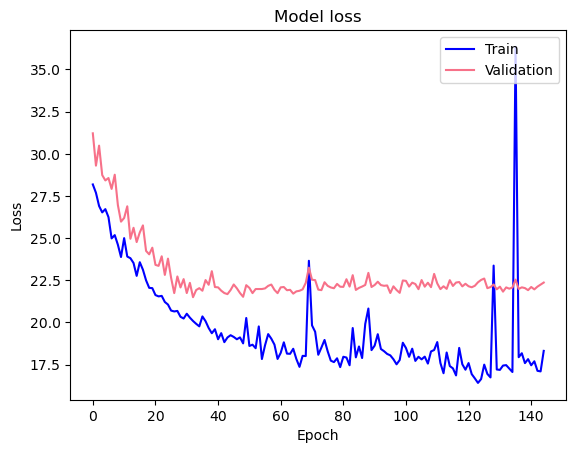

In [299]:
# Plot training & validation loss values
plt.plot(history_dropout.history['loss'][5:], color = 'blue')
plt.plot(history_dropout.history['val_loss'][5:])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

From the plot of the validation and train loss we can see that the model converged. There is some noise due to high levels of dropout regularization which is important for convergence. The out of sample score improved.

To enable convergence I had to increase the complexity of the architecture until 2 layers of 64 nodes. I performed many different trials on levels of regularization both of l1, l2 and dropout, until reaching convergence and an acceptable score. I also tried different learning rates, 0.001 was the optimal level I found.

### Predictions

In [353]:
predicitons = keras_reg_dropout.predict(X_test_preprocessed)
print((predicitons))

164/164 [==============================] - 0s 375us/step
[[1.0645846 ]
 [1.155482  ]
 [1.1365588 ]
 ...
 [1.1314262 ]
 [1.2368166 ]
 [0.89187956]]


Exporting predictions.

In [301]:
nn_results = predicitons

# Produce .csv for kaggle testing
test_predictions_submit = pd.DataFrame({"icustay_id": df_test["icustay_id"], "LOS": nn_results.flatten()})
test_predictions_submit.to_csv("NN_predictions.csv", index = False)

## Ensemble model

### Stacking


For the ensemble model I chose stacking rather than boosting and bagging for two reasons:
- Stacking allows to combine heterogeneous weak learners. This will capture different relationships in the data from their combinination and could provide higher accuracy.
- Boosting and bagging combine homogeneous models and create predictions using deterministic algorithms. Stacking allows to train a meta leearner combining the heterogeneous models, so allows for a more complete level of analysis thanks to the differences of the combined models in terms of variance and bias.


Checking the dimensions stayed constant and no unwanted manipulation occurred.

In [86]:
y_train.shape

(20885,)

### Selecting Best features

I selected the best features to keep in the model using SelectKBest library.

In [87]:
# Initialize SelectKBest with ANOVA F-value, selecting the top 20 features
select_k_best = SelectKBest(f_classif, k=20)

# Fit and transform  to select the top 20 features
X_train_ensemble = select_k_best.fit_transform(X_train_combined, y_train)

# Transform X_test
X_test_ensemble = select_k_best.transform(X_test_combined)

### Weak Learners

the following weak learners were chosen for the ensemble model:
- KNeighborsRegressor (KNN):
Model was chosen because it captures local relationships in the data, suitable for data with consistent feature-target relationships.

- RandomForestRegressor (RF):
This model aggregates predictions from multiple decision trees, reducing overfitting and improving generalization. It ensures additionally solid variance despite it is less robust to bias.

- Lasso (Linear Regression with L1 Regularization):
This model is slighlty more robust than linear regression as it does automatic feature selection by shrinking less important features to zero, aiding in model interpretability and fitting.

- XGBRegressor (XGBoost):
Improves model iteratively by focusing on residuals, leading to better predictive performance. Contrarily to decision trees ensembles it permorms well in terms of bias, but less good for variance, so it can average out the performance of the random forest (which does viceversa).

In [107]:
models_to_include = [
 ('knn', KNeighborsRegressor()),
 ('rf', RandomForestRegressor()),
 ('lr', Lasso()),
 ('xgb', xgb.XGBRegressor())
 ]

### Meta learner

The meta learner will be used to stack the weak learners. The ExtraTreeRegressor was chosen as the meta-learner for the following reasons:

- Robustness: It reduces overfitting by introducing randomness in feature selection and tree construction.

- Bias-Variance Balance: ExtraTrees strikes a good balance between bias and variance, capturing diverse aspects of the data.

- Non-linear Relationships: It can capture complex non-linear patterns in the data.

- Fast Training: ExtraTrees trains quickly, making it suitable for large datasets and time constraints.

- Ease of Use: It's less sensitive to hyperparameters, requiring fewer tweaks for good performance.

In [89]:
meta_learner = ExtraTreesRegressor(    
    n_estimators=50,
    bootstrap=True,
    max_features=0.5)

Defining the stacking ensemble model.

In [ ]:
stacking = StackingRegressor(estimators=models_to_include, final_estimator=meta_learner, cv=3, n_jobs=-1)

### Fitting ensemble model

Performing hyperparameter tuning using halving grid search.

In [91]:
# Tried parameters
# grid_values = {
#               'knn__n_neighbors': [5, 10, 20, 50],
#               'knn__weights': ['distance'],
#               'rf__max_depth':[10, 25, 50, 100, 500],
#               'rf__n_estimators': [100, 200, 500, 650],
#               'rf__min_samples_leaf': [5, 10, 15, 20],
#               'rf__min_samples_split': [2, 5, 10],
#                 'xgb__max_depth': [3, 5, 7], 
#                 'xgb__learning_rate': [0.1, 0.01], 
#                 'xgb__n_estimators': [100, 200] 
# #               }      
  

# Grid search best parameters
grid_values = {
    'knn__n_neighbors': [10],
    'knn__weights': ['distance'],
    'rf__max_depth': [500],
    'rf__n_estimators': [650],
    'rf__min_samples_leaf': [15],
    'rf__min_samples_split': [15],
    'xgb__max_depth': [7], 
    'xgb__learning_rate': [0.1], 
    'xgb__n_estimators': [100] 
}

grid_sl_acc = HalvingGridSearchCV(stacking, param_grid = grid_values, scoring = 'neg_root_mean_squared_error', cv=5, n_jobs=-1,verbose=1)

Fitting the model using halving grid search to decrease runtime while doing hyperparameter tuning.

In [93]:
# Train the ensemble
grid_sl_acc.fit(X_train_ensemble, y_train)

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 85
max_resources_: 20885
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 432
n_resources: 85
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


----------
iter: 1
n_candidates: 144
n_resources: 255
Fitting 5 folds for each of 144 candidates, totalling 720 fits
----------
iter: 2
n_candidates: 48
n_resources: 765
Fitting 5 folds for each of 48 candidates, totalling 240 fits
----------
iter: 3
n_candidates: 16
n_resources: 2295
Fitting 5 folds for each of 16 candidates, totalling 80 fits
----------
iter: 4
n_candidates: 6
n_resources: 6885
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 5
n_candidates: 2
n_resources: 20655
Fitting 5 folds for each of 2 candidates, totalling 10 fits


HalvingGridSearchCV(estimator=StackingRegressor(cv=3,
                                                estimators=[('knn',
                                                             KNeighborsRegressor()),
                                                            ('rf',
                                                             RandomForestRegressor()),
                                                            ('lr', Lasso()),
                                                            ('xgb',
                                                             XGBRegressor(base_score=None,
                                                                          booster=None,
                                                                          callbacks=None,
                                                                          colsample_bylevel=None,
                                                                          colsample_bynode=None,
                                                                          colsample_bytree=None,
                                                                          early_stopping_rounds=None,
                                                                          enable_categorical=False,
                                                                          eval_metric=None,
                                                                          feature_t...
                                                                                    n_estimators=50),
                                                n_jobs=-1),
                    n_jobs=-1,
                    param_grid={'knn__n_neighbors': [10],
                                'knn__weights': ['distance'],
                                'rf__max_depth': [50, 100, 500],
                                'rf__min_samples_leaf': [10, 15],
                                'rf__min_samples_split': [5, 7, 15],
                                'rf__n_estimators': [500, 650],
                                'xgb__learning_rate': [0.1, 0.01],
                                'xgb__max_depth': [3, 5, 7],
                                'xgb__n_estimators': [100, 200]},
                    scoring='neg_root_mean_squared_error', verbose=1)

After fitting the best parameters of coming from the gridsearch are shown below.

In [94]:
print(f'Best parameters: {grid_sl_acc.best_params_}')
print(f'Best score: {-grid_sl_acc.best_score_}')

Best parameters: {'knn__n_neighbors': 10, 'knn__weights': 'distance', 'rf__max_depth': 500, 'rf__min_samples_leaf': 15, 'rf__min_samples_split': 15, 'rf__n_estimators': 650, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__n_estimators': 100}
Best score: 4.651441176565248


In [95]:
best_model = grid_sl_acc.best_estimator_

Computing predictions.

In [110]:
# Predict the test set
prediction = best_model.predict(X_test_ensemble)

Saving the predicitons.

In [111]:
# Save predictions
pred_sl = pd.DataFrame({'icustay_id': df_test['icustay_id'],
                            'LOS': prediction.flatten()})

pred_sl.to_csv(f"./Prediction_sl_stacking.csv", index = False)

### Model Interpretability

After computing the predictions using the fitted model, I will use model interpretability techniques to check feature importance. Using the shap library for this task.

In [99]:
# Summarize the background data using shap.kmeans to deacrease the number of clusters
background_summary = shap.kmeans(X_train_ensemble, 100) 
explainer = shap.KernelExplainer(best_model.predict, background_summary)

  0%|          | 0/20 [00:00<?, ?it/s]

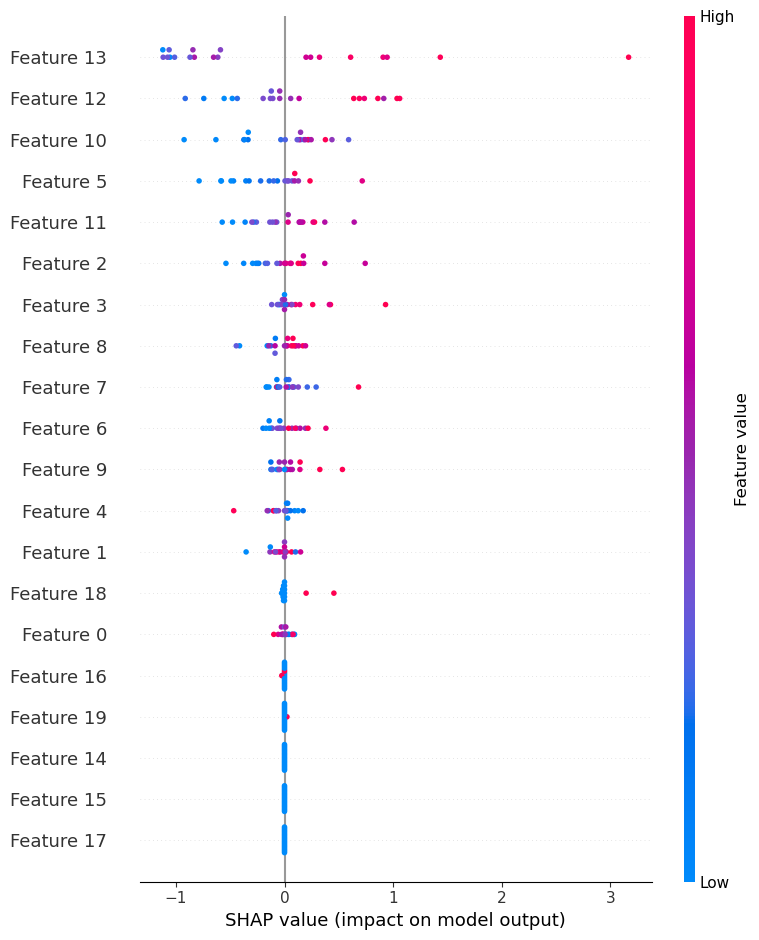

In [101]:
# Compute SHAP values
shap_values = explainer.shap_values(X_test_ensemble[:20])

# Visualize SHAP explanations on the test set
shap.initjs()
shap.summary_plot(shap_values, X_test_ensemble[:20])

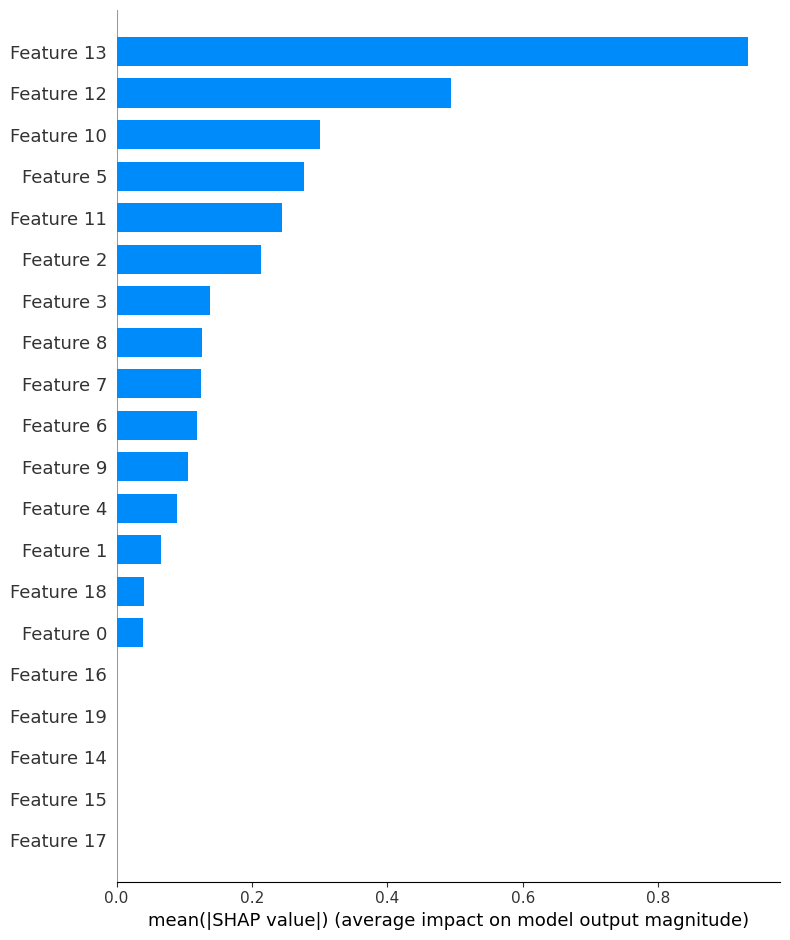

In [102]:
shap.initjs()
shap.summary_plot(shap_values, X_test_ensemble, plot_type="bar")

Observing the plots, the features 13 and 12 are the most relevant for the model when computing predictions. We will check the names of these variables.

In [103]:
# Get the indices of the selected features
selected_feature_indices = select_k_best.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = X_train_combined.columns[selected_feature_indices]

# Print the names of the selected features
print(selected_feature_names)

Index(['HeartRate_Mean', 'RespRate_Mean', 'TempC_Mean', 'SpO2_Mean',
       'DiasBP_Differential', 'Glucose_Differential', 'HeartRate_Differential',
       'MeanBP_Differential', 'RespRate_Differential', 'SpO2_Differential',
       'SysBP_Differential', 'TempC_Differential', 'number_of_diseases',
       'average_mortality', 'ADMISSION_TYPE_URGENT', 'INSURANCE_Self Pay',
       'RELIGION_OTHER', 'ETHNICITY_OTHER', 'FIRST_CAREUNIT_SICU',
       'FIRST_CAREUNIT_TSICU'],
      dtype='object')


In [108]:
print(f"Most important feature of the model: {selected_feature_names[13]}")
print(f"Second most important feature of the model: {selected_feature_names[12]}")

Most important feature of the model: average_mortality
Second most important feature of the model: number_of_diseases


It emerged that the features which are most important for predictions are "average_mortality" and "number_of_diseases" respectively. These were two of the variables I engineered in the process of data manipulation. Average mortality is the outcome of the target encoding of the ICD9 diagnosis variable and number_of_diseases represents the number of comorbidities of the patients. These seem to be the two strongest predictors for length of stay of the patients.

Saving model

In [109]:
# Saving my model
filename = 'stacking_model.sav'
pickle.dump(best_model, open(filename, 'wb'))

# Load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))


### Conclusion

- Ensemble

In my exploration, I've found stacking to be a fascinating ensemble technique. It offers an interesting approach, particularly when using a mix of weak learners with different strengths. Stacking allows to blend predictions from these weak learners using a meta-algorithm to come up with a final prediction.

This insight aligns with the basic principles of bagging and boosting. Bagging typically aims to reduce variation among models, while boosting aims to reduce bias. Consequently, bagging tends to work well with simple models that have higher variability, while boosting prefers models that are more stable but have higher bias.

Therefore, stacking stands out as a promising method, offering the flexibility to include various models with different trade-offs between bias and variance. This adaptability makes it an appealing choice for ensemble learning, providing potential for better predictive performance.

- Neural Network (MLP)

The multilayer perceptron model offers the possibility to approximate any dataset, hence is a very powerful method. Due to the high approximation power it has very high risks of overfitting to the data and give bad out of sample predictions. It is important to increase complexity of the model architecture once simpler models have converged and out of sample predictions align with the model in sample performance. 

For the purposes of this project the MLP worked very well, but was overfitting very quickly. Regularization was crucial, using l1, l2 regularizers and Droppout prevented the model from overfitting and improved out of sample predictions. 